In [5]:
%matplotlib inline
import itertools
import numpy as np
import h5py
import math
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import io
import pandas
import sys

#from collections import namedtuple

#Teneur en eau résiduelle
tr = [0.03]
#Teneur en eau à saturation
ts=np.arange(0.36, 0.46, 0.02, 'float')
#ts= [0.36]
#Teneur en eau initiale
#ti=np.arange(0.05, 0.13, 0.02, 'float')
ti = [0.09]
#Perméabilité à saturation"
Ks=np.arange(0.06, 0.56, 0.05, 'float')
#Ks = [0.21]
#param fitting retention n
#n=np.arange(2, 10.25, 0.25, 'float')
#n=np.arange(2.5, 5., 0.25, 'float')
n = [3.75]
#param fitting retention alpha
#alpha=np.arange(0.01, 0.11, 0.01, 'float')
alpha = [0.02, 0.03, 0.04]
#ts0.4_ti0.09_tr0.03_n9.75_alpha0.09_Ks0.51

In [6]:
l= [ p for p in itertools.product(tr,ts,ti,Ks,n,alpha)]
print(len(l))
print(os.getcwd())

180
/home/sainteno/Porchet-GPR/Jupyter-Notebooks


In [7]:
sys.path.append("../")

from modelisation import Geometry, ParamMVG, ParamGPRMAX

geometry=Geometry()

#Domaine de calcul (en cm)
# largeur
geometry.xmin=0 
geometry.xmax=40
# hauteur (elevation)
geometry.emin=0
geometry.emax = 80
# profondeur du trou en cm
geometry.dtrou = 30
# elevation du fond du trou
geometry.etrou = geometry.emax - geometry.dtrou
 # rayon du trou en cm
geometry.r=4
# hauteur d'eau imposée au fond du trou en cm
geometry.h_eau=5.0
# pas de la maille en cm
geometry.dx = 0.1
#geometry.dx = 1
# profondeur sous le trou (cm) jusqu'où on souhaite un maillage affiné. 
geometry.zaff= 20
#largeur horizontal de la zone affinée (cm)
geometry.waff=20
# elevation de l'affinage
geometry.eaff=geometry.etrou-geometry.zaff 
# contrainte d'angle min pour mesh 
geometry.quality=33
# maximum triangle size  (m*²)
geometry.area=5
# tupple for mesh generation 
geometry.smooth=[1,5]


#Temps d'infiltration où à lieu le calcul de chaque trace  (minutes) 
#temps=[1.00, 2.00]
temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]
temps_volume=[0.50, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]

# Temps max de calcul SWMS2D au delà duquel on arrète le calcul (secondes)
tmax_SWMS2D = 600
#tmax_SWMS2D = 10
   


paramGPRMAX=ParamGPRMAX()
# Domaine de calcul (cm)
paramGPRMAX.xmin = geometry.xmin
paramGPRMAX.xmax = geometry.xmax
paramGPRMAX.zmin = geometry.emin
paramGPRMAX.zmax = geometry.emax
# Taille des mailles (cm)
paramGPRMAX.dx = 1.0 
# Electrical conductivity of the medium
paramGPRMAX.sigma=0.0000
# Relative dielectric permittivity of water
paramGPRMAX.eps_w=80.1
# Relative dielectric permittivity of PVC
paramGPRMAX.eps_pvc=3
# Relative dielectric permittivity of pure silice
paramGPRMAX.eps_s=2.5
# Ricker signal central frequency (Hz)
paramGPRMAX.wave_freq = 1000e6
# Frequence max du signal EM (Hz)
paramGPRMAX.freq_max = 2.8 * paramGPRMAX.wave_freq
# Distance between hole middle and source (m)
paramGPRMAX.d_emet = 0.18
# Distance between hole middle and receiving antenna (m)
paramGPRMAX.d_recept = 0.22
# param qui raffine le pas spatial (par défaut 10 d'après doc gprmax)
paramGPRMAX.spatial_step = 5
# Trace time window (ns)
paramGPRMAX.time = 30e-9
#time_step_stability_factor (pas utilisé pour le moment...)
paramGPRMAX.fac_dt = 0.2 

nT=len(temps)
nV=len(temps_volume)

In [8]:
#lecture fichier de données P1_0_30cm2 Cul-du-chien
from pathlib import Path

twts_data=np.array([0.67,1.032,1.277,1.469,1.617,1.766,2.384,2.841,3.246,3.575,3.841])
volumes_data=np.array([331.752,542.867,914.832,1256.637,1558.23,1910.088,2211.681]) # en cm3

#data_folder = Path("/home/sainteno/Donnees/2018/061218-Cul-du-chien/Fit-avec-baseOUTdtrou30_rtrou4_tr5.0")
#np.savetxt(data_folder / "twts_BilbP1_0_30.txt", twts_data)
#np.savetxt(data_folder / "volumes_BilbP1_0_30.txt", volumes_data)

volumes_data=0.001*volumes_data # en L

In [12]:
def load_simu():

    rows_list = []
    #tableau = pandas.DataFrame(columns=["tr","ts", "ti", "Ks", "n", "alpha", "twts", "volumes"])
    for p in itertools.product(tr,ts,ti,Ks,n,alpha):
        # Definition des paramètres MVG
        paramMVG=ParamMVG(tr=p[0], ts=p[1], ti=p[2], Ks=p[3], n=p[4], alpha=p[5])
        myDirName = "../OUT"+repr(geometry)+"/"+repr(paramMVG)

        ########  TWT #############
        filename = 'TWT'
        if (os.path.isfile(myDirName+"/"+filename)):
            mots=[]
            twts=np.zeros(nT)
            fTWT=open(myDirName+"/"+filename,"r")
            i=0
            for ligne in fTWT:
                ligne = ligne.rstrip(']\n')
                mots = ligne.split(" ")
                for mot in mots:
                    if (mot != '' and mot != '[0.' and mot != '[' and mot != '0.'):
                        twts[i] = float(mot)
                        i=i+1
            fTWT.close()
            ### Volumes
            volumes=np.zeros(nT)
            fVOL=open(myDirName+"/Volumes","r")
            i=0
            for ligne in fVOL:
                ligne = ligne.rstrip(']\n')
                mots = ligne.split(" ")
                for mot in mots:
                    if (mot != '' and mot != '[0.' and mot != '[' and mot != '0.'):
                        volumes[i] = float(mot)
                        i=i+1
            fVOL.close()
            
            #todo: remplacer par l'exemple de nicolas
            volumes_comp=np.zeros(nV)
            volumes_comp[0]=0.001*volumes[2]
            volumes_comp[1]=0.001*volumes[5]
            volumes_comp[2]=0.001*volumes[6]
            volumes_comp[3]=0.001*volumes[7]
            volumes_comp[4]=0.001*volumes[8]
            volumes_comp[5]=0.001*volumes[9]
            volumes_comp[6]=0.001*volumes[10]

            rows_list.append({"tr":p[0],"ts":p[1], "ti":p[2], "Ks":p[3], "n":p[4], "alpha":p[5], "twts":twts, "volumes":volumes_comp})
          
    return pandas.DataFrame(rows_list)


In [13]:
#remplit et copie le tableau avec les resultats des simulations sans les fits

tableau_simu = load_simu()
#print(tableau_simu)
tableau = tableau_simu.copy()

In [14]:
#Calcul des fit

tableau['fit_twts'] = pandas.Series('fit_twts')
tableau['fit_volumes'] = pandas.Series('fit_volumes')
tableau['fit_logtwts'] = pandas.Series('fit_logtwts')
tableau['fit_logvolumes'] = pandas.Series('fit_logvolumes')
tableau['fit_commun'] = pandas.Series('fit_commun')
for j in tableau.index:     
    twts=tableau.at[j,'twts'] 
    volumes= tableau.at[j,'volumes']
    fit_logtwts = np.sqrt(sum((np.log(twts_data)-np.log(twts))**2)/len(twts))
    #print(fit_twts)
    fit_logvolumes = np.sqrt(sum((np.log(volumes_data)-np.log(volumes))**2)/len(volumes_data))
    fit_twts = np.sqrt(sum((twts_data-twts)**2)/len(twts))
    fit_volumes = np.sqrt(sum((volumes_data-volumes)**2)/len(volumes_data))
    fit_commun = (fit_twts+fit_volumes)/2
    tableau.at[j,'fit_twts']=fit_twts
    tableau.at[j,'fit_volumes']=fit_volumes
    tableau.at[j,'fit_logtwts']=fit_logtwts
    tableau.at[j,'fit_logvolumes']=fit_logvolumes
    tableau.at[j,'fit_commun']=fit_commun

#print(tableau)

In [18]:
#Calcul des fit min
fit_twts = tableau['fit_twts']
fit_min_twts=np.min(fit_twts)
ifit_min_twts = int(np.where(fit_twts[:] == fit_min_twts)[0])
print(fit_min_twts)
print(ifit_min_twts)
print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_min={min}
        """.format(tr=tableau.at[ifit_min_twts,"tr"], 
                   ts=tableau.at[ifit_min_twts,"ts"], 
                   ti=tableau.at[ifit_min_twts,"ti"], 
                   Ks=tableau.at[ifit_min_twts,"Ks"], 
                   n=tableau.at[ifit_min_twts,"n"], 
                   alpha=tableau.at[ifit_min_twts,"alpha"],
                   min=fit_min_twts)
     )

fit_volumes = tableau['fit_volumes']
fit_min_vols=np.min(fit_volumes)
ifit_min_vols = int(np.where(fit_volumes[:] == fit_min_vols)[0])
print(fit_min_vols)
print(ifit_min_vols)
print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_min={min}
        """.format(tr=tableau.at[ifit_min_vols,"tr"], 
                   ts=tableau.at[ifit_min_vols,"ts"], 
                   ti=tableau.at[ifit_min_vols,"ti"], 
                   Ks=tableau.at[ifit_min_vols,"Ks"], 
                   n=tableau.at[ifit_min_vols,"n"], 
                   alpha=tableau.at[ifit_min_vols,"alpha"],
                   min=fit_min_vols)
     )

0.06106700362750777
8
tr=0.03,ts=0.36,ti=0.09,Ks=0.26,n=3.75,alpha=0.04,fit_min=0.06106700362750777
        
0.07108894906182174
110
tr=0.03,ts=0.4600000000000001,ti=0.09,Ks=0.21000000000000002,n=3.75,alpha=0.04,fit_min=0.07108894906182174
        


In [19]:
#Calcul du minimum du fit commun 
fit_commun = tableau['fit_commun']
fit_min_commun=np.min(fit_commun)
ifit_min_commun = int(np.where(fit_commun[:] == fit_min_commun)[0])
print(fit_min_commun)
print(ifit_min_commun)
print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_commun={min1},fit_twts={min2},fit_vols={min3}
        """.format(tr=tableau.at[ifit_min_commun,"tr"], 
                   ts=tableau.at[ifit_min_commun,"ts"], 
                   ti=tableau.at[ifit_min_commun,"ti"], 
                   Ks=tableau.at[ifit_min_commun,"Ks"], 
                   n=tableau.at[ifit_min_commun,"n"], 
                   alpha=tableau.at[ifit_min_commun,"alpha"],
                   min1=tableau.at[ifit_min_commun,"fit_commun"],
                   min2=tableau.at[ifit_min_commun,"fit_twts"],
                   min3=tableau.at[ifit_min_commun,"fit_volumes"])
     )

0.08327393191757186
8
tr=0.03,ts=0.36,ti=0.09,Ks=0.26,n=3.75,alpha=0.04,fit_commun=0.08327393191757186,fit_twts=0.06106700362750777,fit_vols=0.10548086020763596
        


# plot de comparaison best-models et data

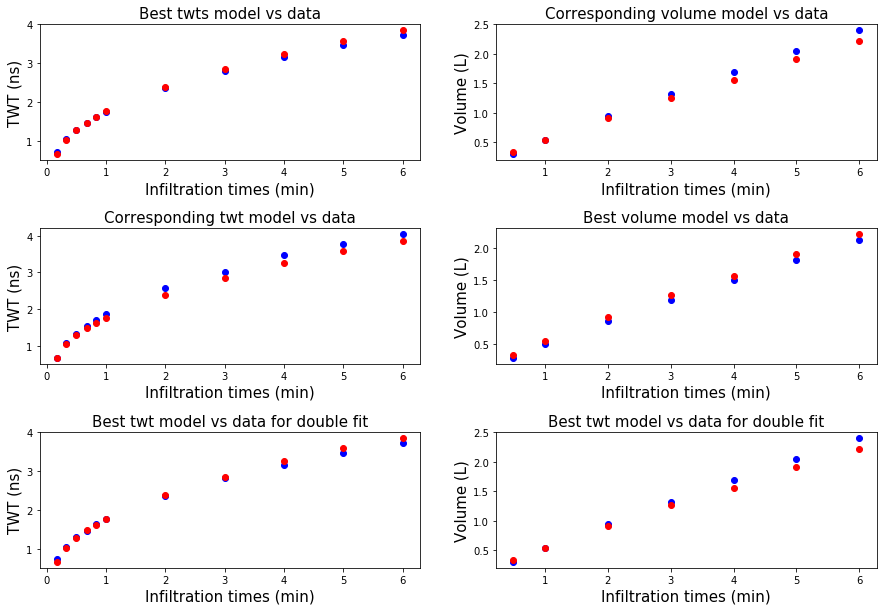

In [20]:
%matplotlib inline
fig = plt.figure(1,figsize=(15,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().subplots_adjust(hspace =.5)
    
plt.subplot(3,2,1)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('TWT (ns)',fontsize=15)
plt.title('Best twts model vs data',fontsize=15)
plt.plot(temps,tableau.at[ifit_min_twts, "twts"], 'bo')
plt.plot(temps,twts_data, 'ro')

plt.subplot(3,2,2)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('Volume (L)',fontsize=15)
plt.title('Corresponding volume model vs data',fontsize=15)
plt.plot(temps_volume,tableau.at[ifit_min_twts, "volumes"], 'bo')
plt.plot(temps_volume,volumes_data, 'ro')

plt.subplot(3,2,3)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('TWT (ns)',fontsize=15)
plt.title('Corresponding twt model vs data',fontsize=15)
plt.plot(temps,tableau.at[ifit_min_vols, "twts"], 'bo')
plt.plot(temps,twts_data, 'ro')

plt.subplot(3,2,4)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('Volume (L)',fontsize=15)
plt.title('Best volume model vs data',fontsize=15)
plt.plot(temps_volume, tableau.at[ifit_min_vols, "volumes"], 'bo')
plt.plot(temps_volume,volumes_data, 'ro')

plt.subplot(3,2,5)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('TWT (ns)',fontsize=15)
plt.title('Best twt model vs data for double fit',fontsize=15)
plt.plot(temps,tableau.at[ifit_min_commun, "twts"], 'bo')
plt.plot(temps,twts_data, 'ro')

plt.subplot(3,2,6)
plt.xlabel('Infiltration times (min)',fontsize=15)
plt.ylabel('Volume (L)',fontsize=15)
plt.title('Best twt model vs data for double fit',fontsize=15)
plt.plot(temps_volume, tableau.at[ifit_min_commun, "volumes"], 'bo')
plt.plot(temps_volume,volumes_data, 'ro')

plt.savefig('bilbP1_0_30.pdf', bbox_inches='tight')

In [21]:
#selection des modèles qui fit à 0.1 ns près
fit_commun = tableau['fit_commun']
ifit_1ns = np.where(fit_commun[:] < 0.1)[0]
nfit=len(ifit_1ns)
print(nfit)

1


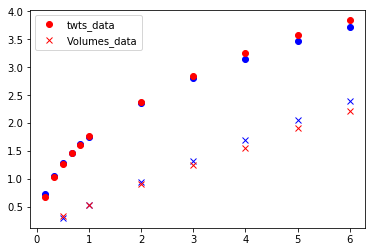

In [22]:
#plot pour comparer avec les donnees terrain
%matplotlib inline

#fig, ax = plt.subplots(2, figsize=(10, 10))

for i in range(nfit):
    plt.plot(temps, tableau.at[int(ifit_1ns[i]),"twts"], 'bo')        
plt.plot(temps, twts_data, 'ro', label='twts_data')
plt.legend(fontsize=20)

for i in range(nfit):
    plt.plot(temps_volume, tableau.at[int(ifit_1ns[i]),"volumes"], 'bx') 
plt.plot(temps_volume, volumes_data, 'rx', label='Volumes_data')  
plt.legend(fontsize=10)

plt.savefig('bilbP1_0_30-mVSdata-less0.065.pdf',bbox_inches='tight')

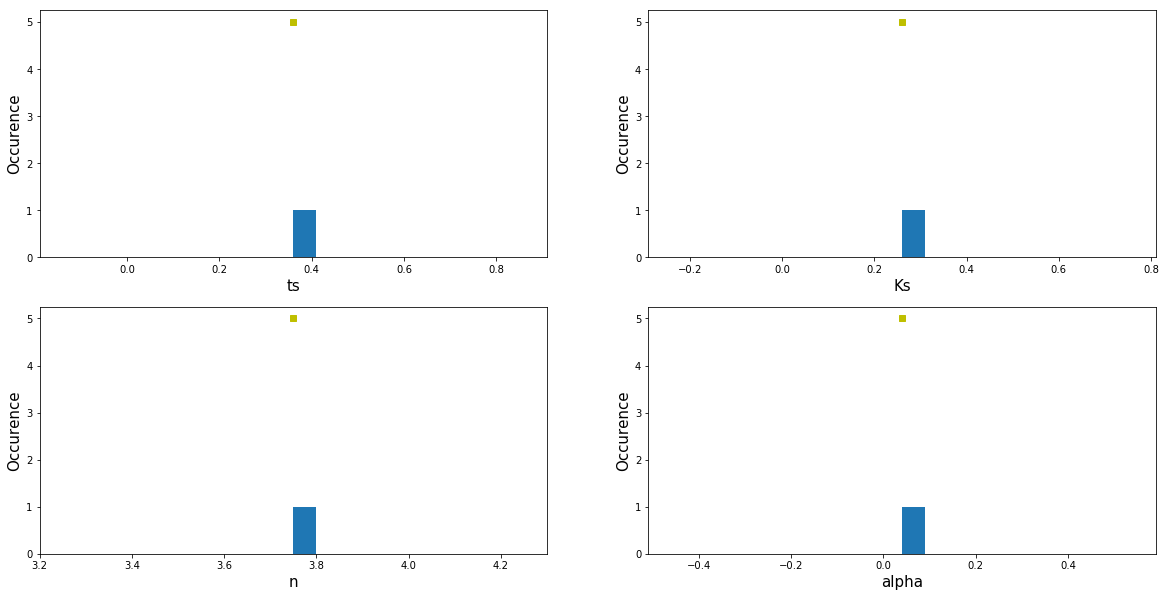

In [23]:
fig = plt.figure(1,figsize=(20,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(2,2,1)
plt.xlabel('ts',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
resu = np.zeros(nfit)
for i in range(nfit): 
    resu[i] = tableau.at[int(ifit_1ns[i]),"ts"] 
plt.hist(resu,bins=20)
plt.plot(tableau.at[int(ifit_min_commun),"ts"],5, 'ys')

plt.subplot(2,2,2)
plt.xlabel('Ks',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
resu = np.zeros(nfit)
for i in range(nfit): 
    resu[i] = tableau.at[int(ifit_1ns[i]),"Ks"] 
plt.hist(resu,bins=20)
plt.plot(tableau.at[int(ifit_min_commun),"Ks"],5, 'ys')

plt.subplot(2,2,3)
plt.xlabel('n',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
resu = np.zeros(nfit)
for i in range(nfit): 
    resu[i] = tableau.at[int(ifit_1ns[i]),"n"] 
plt.hist(resu,bins=20)
plt.plot(tableau.at[int(ifit_min_commun),"n"],5, 'ys')

plt.subplot(2,2,4)
plt.xlabel('alpha',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
resu = np.zeros(nfit)
for i in range(nfit): 
    resu[i] = tableau.at[int(ifit_1ns[i]),"alpha"] 
plt.hist(resu,bins=20)
plt.plot(tableau.at[int(ifit_min_commun),"alpha"],5, 'ys')

plt.savefig('bilbP1_0_30-less0.065.pdf',bbox_inches='tight')
#plt.show(1)
#plt.close(1)

 # Plot des fit en fonction des param

5.653627802502538


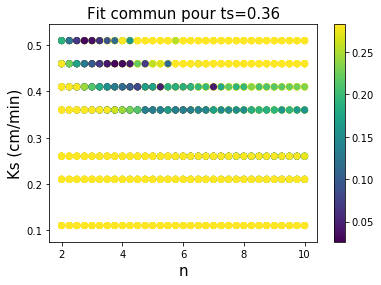

In [15]:
n = np.array(tableau["n"][tableau["ts"]==0.36])
Ks = np.array(tableau["Ks"][tableau["ts"]==0.36])
alpha = np.array(tableau["alpha"][tableau["ts"]==0.36])
z = np.array(tableau["fit_commun"][tableau["ts"]==0.36], dtype=float)
z_min=min(z)
z_max=max(z)
print(z_max)


fig, ax = plt.subplots()
scat = ax.scatter(n, Ks, c=z,marker='o',vmin=z_min,vmax=z_max/20)
fig.colorbar(scat)
ax.set_title('Fit commun pour ts=0.36',fontsize=15)
ax.set_xlabel('n',fontsize=15)
ax.set_ylabel('Ks (cm/min)',fontsize=15)

plt.show()

In [9]:
#Calcul des fit min pour les log
fit_logtwts = tableau['fit_logtwts']
fit_min_logtwts=np.min(fit_logtwts)
ifit_min_logtwts = int(np.where(fit_logtwts[:] == fit_min_logtwts)[0])
print(fit_min_logtwts)
print(ifit_min_logtwts)
print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_min={min}
        """.format(tr=tableau.at[ifit_min_logtwts,"tr"], 
                   ts=tableau.at[ifit_min_logtwts,"ts"], 
                   ti=tableau.at[ifit_min_logtwts,"ti"], 
                   Ks=tableau.at[ifit_min_logtwts,"Ks"], 
                   n=tableau.at[ifit_min_logtwts,"n"], 
                   alpha=tableau.at[ifit_min_logtwts,"alpha"],
                   min=fit_min_logtwts)
     )


fit_logvolumes = tableau['fit_logvolumes']
fit_min_logvols=np.min(fit_logvolumes)
ifit_min_logvols = int(np.where(fit_logvolumes[:] == fit_min_logvols)[0])
print(fit_min_logvols)
print(ifit_min_logvols)
print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_min={min}
        """.format(tr=tableau.at[ifit_min_logvols,"tr"], 
                   ts=tableau.at[ifit_min_logvols,"ts"], 
                   ti=tableau.at[ifit_min_logvols,"ti"], 
                   Ks=tableau.at[ifit_min_logvols,"Ks"], 
                   n=tableau.at[ifit_min_logvols,"n"], 
                   alpha=tableau.at[ifit_min_logvols,"alpha"],
                   min=fit_min_logvols)
     )

0.019194723446914384
3562
tr=0.03,ts=0.4600000000000001,ti=0.09,Ks=0.11,n=10.0,alpha=0.03,fit_min=0.019194723446914384
        
0.03820790534719946
3574
tr=0.03,ts=0.4600000000000001,ti=0.09,Ks=0.21000000000000002,n=2.75,alpha=0.03,fit_min=0.03820790534719946
        


4.262317724310288


NameError: name 'matplotlib' is not defined

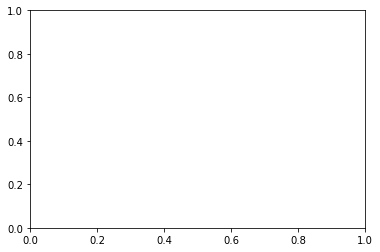

In [16]:
n = np.array(tableau["n"])
Ks = np.array(tableau["Ks"])
alpha = np.array(tableau["alpha"])
z = np.array(tableau["fit_twts"], dtype=float)
z_min=min(z)
z_max=max(z)
print(z_max)
fig, ax = plt.subplots()
map= matplotlib.cm.get_cmap(name='jet')
scat = ax.scatter(n, alpha, c=z,marker='o',vmin=z_min,vmax=z_max/2)
fig.colorbar(scat)

plt.show()

In [ ]:
import ipyvolume as ipv
import matplotlib.cm
map= matplotlib.cm.get_cmap(name='jet')
x = np.array(tableau["n"][tableau["ts"]==0.36])
y = np.array(tableau["Ks"][tableau["ts"]==0.36])
z = np.array(tableau["alpha"][tableau["ts"]==0.36])
f = (np.array(tableau["fit_commun"][tableau["ts"]==0.36], dtype=float))
f_min=min(f)
f_max=max(f)
f_norme=((f-f_min)/(f_max-f_min))


ipv.quickscatter(x, y, z, color=map(f),size=2, marker="sphere")
ipv.xlim(min(x),max(x))
ipv.ylim(min(y),max(y))
ipv.zlim(min(z),max(z))
print(min(z),max(z))
ipv.xlabel('n')
ipv.ylabel('Ks (cm/min)')
ipv.zlabel('alpha (1/cm)')
ipv.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(n, Ks, alpha, c='r', marker='o')

ax.set_xlabel('n')
ax.set_ylabel('Ks')
ax.set_zlabel('Alpha')

plt.show()

# Plot pour les fit calculer sur les logs

In [ ]:
#selection des modèles qui fit à 0.1 ns près
fit_logtwts = tableau['fit_logtwts']
#ifit_1ns_logtwts = np.where(fit_logtwts[:] < 0.05)[0]
nfit=len(ifit_1ns_logtwts)
print(nfit)

In [ ]:
#plot pour comparer avec les donnees terrain
%matplotlib inline

#fig, ax = plt.subplots(2, figsize=(10, 10))

for i in range(nfit):
    plt.plot(temps, tableau.at[int(ifit_1ns_logtwts[i]),"twts"], 'ro')        
plt.plot(temps, twts_data, 'bo', label='twts_data')
plt.legend(fontsize=20)

for i in range(nfit):
    plt.plot(temps_volume, tableau.at[int(ifit_1ns_logtwts[i]),"volumes"], 'rx') 
plt.plot(temps_volume, volumes_data, 'bx', label='Volumes_data')  
plt.legend(fontsize=10)

print("""tr={tr},ts={ts},ti={ti},Ks={Ks},n={n},alpha={alpha},fit_minV={minV}
        """.format(tr=p[0], ts=p[1], ti=p[2], Ks=p[3], n=p[4], alpha=p[5],minV=fit_min_logtwts)
     )

# Tests 

In [ ]:
for p in itertools.product(tr,ts,ti,Ks,n,alpha):
    # Definition des paramètres MVG
    paramMVG=ParamMVG(tr=p[0], ts=p[1], ti=p[2], Ks=p[3], n=p[4], alpha=p[5])

    myDirName = "OUT"+repr(geometry)+"/"+repr(paramMVG)
    
    ####### Param ########
    param_fichier = io.open(myDirName+"/Parameters").read()
    p2 = eval(param_fichier)
    print("p",p)
    print(p2)

In [ ]:
[  v    for v in fit_volumes if v <22]        
[  (i,fit_volumes[i], l[i])    for i in range(len(fit_volumes))    if  fit_volumes[i] <22.]    